In [2]:
import numpy as np
import pandas as pd
import sklearn
import time
import re
import string
from sklearn.decomposition import IncrementalPCA, SparsePCA, PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
import sklearn
import scipy
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
shortX = pd.read_csv("../imdbmovies/features.csv")
fullX = pd.read_csv("../imdbmovies/features_vectorized.csv")
words50X = pd.read_csv("../imdbmovies/vectorization50.csv", header=None)
labelsY = pd.read_csv("../imdbmovies/labels.csv")

In [6]:
shortX.pop('title')

0                           the vagabond and the child
1                                            gold rush
2                                            metropoli
3                                          the general
4                                           citi light
                             ...                      
10092                                       scaramouch
10093                                     you cant win
10094                                   runway to luck
10095         the adventur of ichabod and taddäus toad
10096    a yanke from connecticut to king arthur court
Name: title, Length: 10097, dtype: object

# Modeling

- test various C values
- used dual = False for model bc n_samples > n_features
- used 90/10 split for training and testing
- used decision function to predict y values, where all > 0 values were chosen as the predicted class else the max value was the predicted class
- using no titles, full titles, and PCA of Full Titles where 50% of the variance is explained (773)

In [7]:
def get_pred(arr):
    if arr[arr  > 0].size == 0:
        result = np.zeros(arr.shape)
        maxIdx = np.argmax(arr)
        result[maxIdx] = 1
        return result
    else:
        result = arr
        result[result > 0] = 1
        result[result <= 0] = 0
        return result

In [8]:
C = [math.exp((x-5)/10)/10000 for x in range(0, 150, 10)] 

# Optimze C Value

Accuracy stays the same over C values, thus use the default of c=1

In [9]:
score = {}
loss = {}
titleKey = {0: "No Title Data", 1: "50% Covar Title Data", 2: "Full Title Data"}
for i, X in enumerate((shortX, shortX.join(words50X), fullX)):
    title = titleKey[i]
    score[title] = {}
    loss[title] = {}
    print("Starting trial ", i)
    for c in C:
        score[title][c] = []
        loss[title][c] = []
        for _ in range(10):
            X_train, X_test, y_train, y_test  = train_test_split(X, labelsY, test_size=.1)
            SVM = LinearSVC(dual=False, max_iter=1000, C=c)
            clf = OneVsRestClassifier(SVM)
            clf.fit(X_train, y_train)
            y_pred = clf.decision_function(X_test)
            y_pred = np.apply_along_axis(get_pred, 1, y_pred)
            ham_loss = hamming_loss(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            score[title][c].append(acc)
            loss[title][c].append(ham_loss)
        print("Finished for c = ", c)

Starting trial  0
Finished for c =  6.065306597126334e-05
Finished for c =  0.0001648721270700128
Finished for c =  0.00044816890703380644
Finished for c =  0.0012182493960703473
Finished for c =  0.0033115451958692314
Finished for c =  0.00900171313005218
Finished for c =  0.024469193226422038
Finished for c =  0.06651416330443619
Finished for c =  0.1808042414456063
Finished for c =  0.4914768840299134
Finished for c =  1.3359726829661873
Finished for c =  3.6315502674246636
Finished for c =  9.87157710107605
Finished for c =  26.833728652087448
Finished for c =  72.94163698477013
Starting trial  1
Finished for c =  6.065306597126334e-05
Finished for c =  0.0001648721270700128
Finished for c =  0.00044816890703380644
Finished for c =  0.0012182493960703473
Finished for c =  0.0033115451958692314
Finished for c =  0.00900171313005218
Finished for c =  0.024469193226422038
Finished for c =  0.06651416330443619
Finished for c =  0.1808042414456063
Finished for c =  0.4914768840299134
Fi

<Figure size 432x288 with 0 Axes>

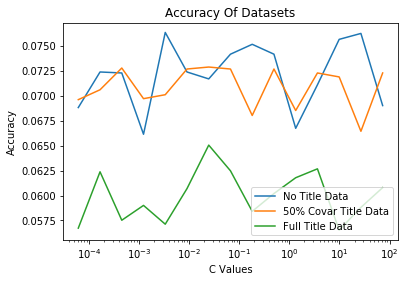

In [10]:
plt.clf()
_, ax = plt.subplots()
for dataTitle, dataDict in score.items():    
    avgScore = {k:np.mean(np.array(v)) for k,v in dataDict.items()}
    lists = sorted(avgScore.items())
    x_plot, y_plot = zip(*lists)
    ax.plot(x_plot, y_plot, label=dataTitle)
plt.ylabel("Accuracy")
plt.xlabel("C Values")
plt.title("Accuracy Of Datasets")
ax.set_xscale('log')
plt.legend(loc='lower right')
# plt.savefig("./figures/DatasetvAccuracy.png")
plt.show()

<Figure size 432x288 with 0 Axes>

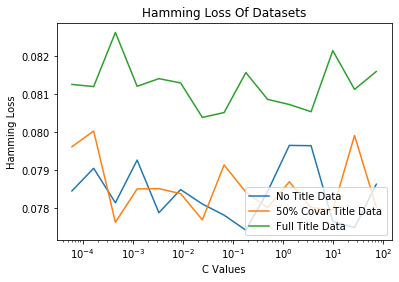

In [11]:
plt.clf()
_, ax = plt.subplots()
for dataTitle, dataDict in loss.items():    
    avgLoss = {k:np.mean(np.array(v)) for k,v in dataDict.items()}
    lists = sorted(avgLoss.items())
    x_plot, y_plot = zip(*lists)
    ax.plot(x_plot, y_plot, label=dataTitle)
plt.ylabel("Hamming Loss")
plt.xlabel("C Values")
plt.title("Hamming Loss Of Datasets")
ax.set_xscale('log')
plt.legend(loc='lower right')
# plt.savefig("./figures/DatasetvHammingLoss.png")
plt.show()

# Comparing Performance

In [ ]:
trialLoss = {v: [] for k, v in titleKey.items()}
trialScore = {v: [] for k, v in titleKey.items()}
for t in range(15):
    for i, X in enumerate((shortX, shortX.join(words50X), fullX)):
        title = titleKey[i]
        X_train, X_test, y_train, y_test  = train_test_split(X, labelsY, test_size=.1)
        SVM = LinearSVC(dual=False, max_iter=10000)
        clf = OneVsRestClassifier(SVM)
        clf.fit(X_train, y_train)
        y_pred = clf.decision_function(X_test)
        y_pred = np.apply_along_axis(get_pred, 1, y_pred)
        ham_loss = hamming_loss(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        trialScore[title].append(acc)
        trialLoss[title].append(ham_loss)

## Accuracy Score

<Figure size 432x288 with 0 Axes>

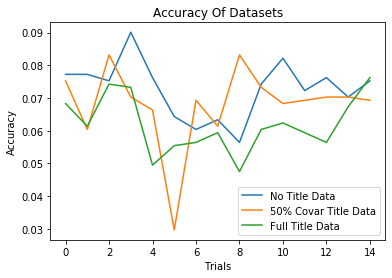

In [62]:
plt.clf()
_, ax = plt.subplots()
for k, v in trialScore.items():
    ax.plot(v, label=k)
plt.ylabel("Accuracy")
plt.xlabel("Trials")
plt.title("Accuracy Of Datasets")
plt.legend(loc='lower right')
plt.savefig("../figures/DatasetvAccuracy.png")
plt.show()

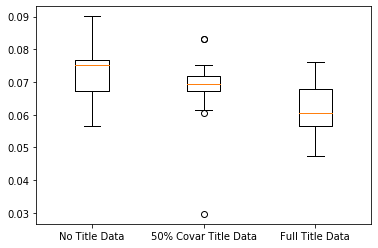

In [63]:
colScore = np.zeros((15, 3))
i = 0
for k, v in trialScore.items():
    colScore[:, i] = np.array(v)
    i += 1
plt.clf()
plt.boxplot(colScore, labels=list(trialScore.keys()))
plt.savefig("../figures/DatasetvAccuracyBoxPlot.png")
plt.show()

## Hamming Loss

<Figure size 432x288 with 0 Axes>

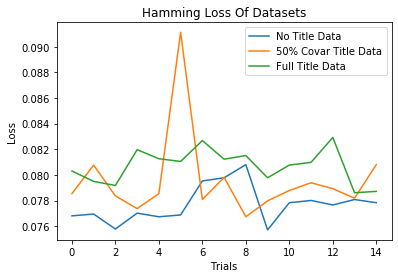

In [66]:
plt.clf()
_, ax = plt.subplots()
for k, v in trialLoss.items():
    ax.plot(v, label=k)
plt.ylabel("Loss")
plt.xlabel("Trials")
plt.title("Hamming Loss Of Datasets")
plt.legend(loc='upper right')
plt.savefig("../figures/DatasetvHammingLoss.png")
plt.show()

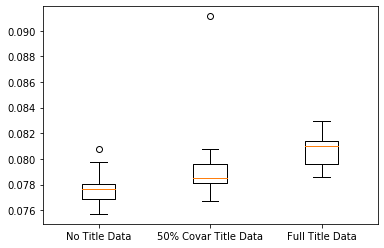

In [65]:
colScore = np.zeros((15, 3))
i = 0
for k, v in trialLoss.items():
    colScore[:, i] = np.array(v)
    i += 1
plt.clf()
plt.boxplot(colScore, labels=list(trialLoss.keys()))
plt.savefig("../figures/DatasetvHammingLossBoxPlot.png")
plt.show()

# Effects of PCA on non Movie Title

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA().fit(shortX)

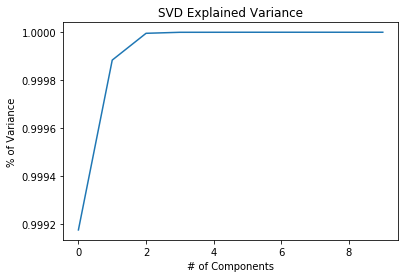

In [67]:
variances = np.cumsum(pca.explained_variance_ratio_)
plt.plot(variances)
plt.xlabel("# of Components")
plt.ylabel("% of Variance")
plt.title("SVD Explained Variance")
plt.savefig("../figures/PCAvExplainedVariance.png")
plt.show()

In [50]:
tempScore = {}
for comp in range(1, 6):
    tempX = PCA(comp).fit_transform(shortX)
    tempScore[comp] = []
    print("PCA with {} components".format(comp))
    for _ in range(20):
        X_train, X_test, y_train, y_test  = train_test_split(tempX, labelsY, test_size=.1)
        SVM = LinearSVC(dual=False, max_iter=1000)
        clf = OneVsRestClassifier(SVM)
        clf.fit(X_train, y_train)
        y_pred = clf.decision_function(X_test)
        y_pred = np.apply_along_axis(get_pred, 1, y_pred)
        acc = accuracy_score(y_test, y_pred)
        tempScore[comp].append(acc)

PCA with 1 components
PCA with 2 components
PCA with 3 components
PCA with 4 components
PCA with 5 components


<Figure size 432x288 with 0 Axes>

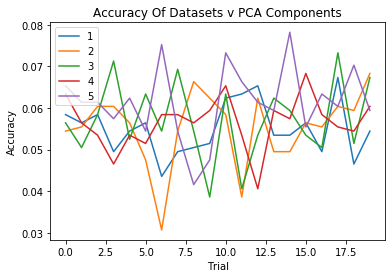

In [60]:
plt.clf()
_, ax = plt.subplots()
for dataTitle, dataDict in tempScore.items():    
    ax.plot(dataDict, label=dataTitle)
plt.ylabel("Accuracy")
plt.xlabel("Trial")
plt.title("Accuracy Of Datasets v PCA Components")
plt.legend(loc='upper left')
plt.savefig("../figures/PCA_v_Accuracy.png")
plt.show()

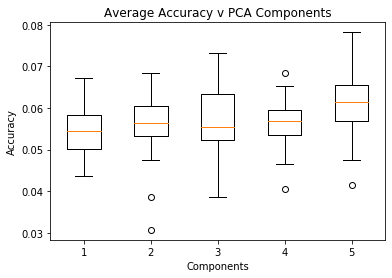

In [68]:
colPCAScore = np.zeros((20, 5))
i = 0
for k, v in tempScore.items():
    colPCAScore[:, i] = np.array(v)
    i += 1
plt.clf()
plt.ylabel("Accuracy")
plt.xlabel("Components")
plt.title("Average Accuracy v PCA Components")
plt.boxplot(colPCAScore, labels=list(tempScore.keys()))
plt.savefig("../figures/PCA_v_AccuracyBoxPlot.png")
plt.show()